In [4]:
#Install transformers which contains pre-trained BERT in PyTorch 
!pip install transformers==3

In [5]:
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split


from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import requests

In [6]:
data = pd.read_csv("twss.csv").drop("Unnamed: 0", axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4014 non-null   object
 1   twss      4014 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.8+ KB


In [8]:
data["sentence"] = data["sentence"].astype(str)

In [9]:
from transformers import BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
sentences_tokens_ids = []
max_len = ["", 0]
for i in range(len(data)):
    s = data["sentence"][i]
    t = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s))
    sentences_tokens_ids.append(t)
    if len(t) > max_len[1]:
        max_len[0] = s
        max_len[1] = len(t)

sentences_lengths = [len(s) for s in sentences_tokens_ids]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


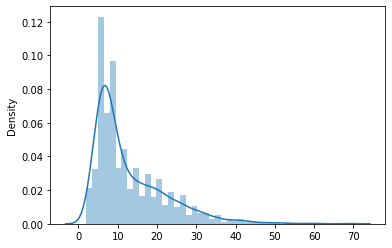

In [11]:
import seaborn as sns

sns.distplot(sentences_lengths)

We don't need really long sentences so we crop our data, we just keep the sentences that have number of words < 20

In [12]:
MAX_LENGTH = 50 #this is the max number of tokens per feature

data = data[(data.sentence.str.split().str.len() < 20)]

In [13]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data = data.drop("index", axis=1)

In [14]:
#Apply tokenization + adding special tokens [SEP] [CLS]
encoding = tokenizer.encode_plus(
  data["sentence"][0],
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [15]:
class SentenceDataset:
    def __init__(self, data, max_length, tokenizer):
        self.data = data
        self.length = len(data)
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return self.length

    def __getitem__(self, id):
        s = self.data["sentence"][id]
        i = self.data["twss"][id]

        encoding = self.tokenizer.encode_plus(
            s,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True, 
        )

        return {
            'message': s,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(i, dtype=torch.long)
        }

dataset = SentenceDataset(data, MAX_LENGTH, tokenizer)

In [16]:
train, test = train_test_split(data, test_size=0.1)

train = train.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
train = train.drop("index", axis=1)

test = test.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
test = test.drop("index", axis=1)

train_dataset = SentenceDataset(train, MAX_LENGTH, tokenizer)
test_dataset = SentenceDataset(test, MAX_LENGTH, tokenizer)



In [17]:
train_data_loader = DataLoader(train_dataset, batch_size=16)
test_data_loader  = DataLoader(test_dataset, batch_size=16)

dataset_loader  = DataLoader(dataset, batch_size=16)

In [18]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Try to use it with our first sampled text 
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [19]:
class TwssModel(nn.Module):
    def __init__(self):
        super(TwssModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return torch.sigmoid(self.out(output))

In [20]:
def train_epoch(model, dataset_loader, loss_fn, optimiser, device):
    model.train()

    losses = []
    correct_predictions = 0

    for d in dataset_loader:
        optimiser.zero_grad()

        input_ids = d["input_ids"].to(device)
        attention_masks = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_masks
        )

        preds = outputs.round().resize(outputs.shape[0])

        loss = loss_fn(outputs.resize(outputs.shape[0]).float(),targets.float())

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        #print("                    Loss: ",loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()

        

    return correct_predictions.double().item() / len(train_dataset), np.mean(losses)


In [21]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = outputs.round().resize(outputs.shape[0])

            loss = loss_fn(outputs.resize(outputs.shape[0]).float(), targets.float())
        
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double().item() / len(test_dataset), np.mean(losses)

In [22]:
history = {
    "train_acc": [],
    "train_loss": [],
    "val_acc": [],
    "val_loss": []
}

best_accuracy = 0

model = TwssModel()
model = model.to(device)

EPOCHS = 10

opt = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCELoss().to(device)

total_steps = len(dataset_loader) * EPOCHS



for epoch in range(1, EPOCHS + 1):

    print(f"[EPOCHS]    Epoch: {epoch}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, opt, device)

    print(f"[TRAIN]     Train loss: {train_loss}    Train accuracy: {train_acc}")

    eval_acc, eval_loss = eval_model(model, test_data_loader, loss_fn, device)

    print(f"[EVAL]      Eval loss : {eval_loss}    Eval accuracy : {eval_acc}")

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_acc)
    history['val_loss'].append(eval_loss)

    if eval_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/data/twss/drivebest_model_state.bin')

    print("\n\n")


[EPOCHS]    Epoch: 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[TRAIN]     Train loss: 0.33555071292697786    Train accuracy: 0.8574120603015075
[EVAL]      Eval loss : 0.15154200500768164    Eval accuracy : 0.9519774011299436



[EPOCHS]    Epoch: 2/10
----------
[TRAIN]     Train loss: 0.12221283147499976    Train accuracy: 0.9635678391959799
[EVAL]      Eval loss : 0.12820938700789827    Eval accuracy : 0.9717514124293786



[EPOCHS]    Epoch: 3/10
----------
[TRAIN]     Train loss: 0.07449747608031554    Train accuracy: 0.9827261306532663
[EVAL]      Eval loss : 0.12289802323768685    Eval accuracy : 0.9745762711864406



[EPOCHS]    Epoch: 4/10
----------
[TRAIN]     Train loss: 0.027670681650923498    Train accuracy: 0.9921482412060302
[EVAL]      Eval loss : 0.163886914843992    Eval accuracy : 0.9717514124293786



[EPOCHS]    Epoch: 5/10
----------
[TRAIN]     Train loss: 0.012578337365555478    Train accuracy: 0.996859296482412
[EVAL]      Eval loss : 0.19712102323366865    Eval accuracy : 0.9717514124293786



[EPOCHS]    Epoch: 6/10
--

In [23]:
def test_sentence(s, model, tokenizer):
    encoding = tokenizer.encode_plus(
            s,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True, 
        )

    
    output = model(
        input_ids=encoding['input_ids'].flatten().resize(1, 50).to(device),
        attention_mask=encoding['attention_mask'].flatten().resize(1, 50).to(device)
    )

    print(s)
    print(output.item())
    c =  output.resize(1).round().item()
    if c == 0:
        print("Naaaah")
    else:
        print("THAT'S WHAT SHE SAID")
    

In [25]:
best_model = TwssModel().to(device)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/data/twss/drivebest_model_state.bin"))

<All keys matched successfully>

In [26]:
sentences = """
I'm doing good, I'm on some new shit
Been saying "yes" instead of "no"
I thought I saw you at the bus stop, I didn't though
I hit the ground running each night
I hit the Sunday matinée
You know the greatest films of all time were never made
I guess you never know, never know
And if you wanted me, you really should've showed
And if you never bleed, you're never gonna grow
And it's alright now
But we were something, don't you think so?
Roaring twenties, tossing pennies in the pool
And if my wishes came true
It would've been you
In my defense, I have none
For never leaving well enough alone
But it would've been fun
If you would've been the one
I had this dream you're doing cool shit
Having adventures on your own
You meet some woman on the internet and take her… 
"""

sentences = [s.lower() for s in sentences.split("\n")]

for s in sentences:
    print(s)
    test_sentence(s, best_model, tokenizer)
    print("--------------")



0.003698958083987236
Naaaah
--------------
nice to meet you, where you been?
nice to meet you, where you been?
3.862219091388397e-05
Naaaah
--------------
i could show you incredible things
i could show you incredible things
8.096833335002884e-05
Naaaah
--------------
magic, madness, heaven, sin
magic, madness, heaven, sin
0.999983549118042
THAT'S WHAT SHE SAID
--------------
saw you there and i thought
saw you there and i thought
0.0368991419672966
Naaaah
--------------
"oh, my god, look at that face
"oh, my god, look at that face
0.9999812841415405
THAT'S WHAT SHE SAID
--------------
you look like my next mistake
you look like my next mistake
6.733382178936154e-05
Naaaah
--------------
love's a game, wanna play?" ay
love's a game, wanna play?" ay
0.999982476234436
THAT'S WHAT SHE SAID
--------------
new money, suit and tie
new money, suit and tie
2.1299849322531372e-05
Naaaah
--------------
i can read you like a magazine
i can read you like a magazine
6.188291445141658e-05
Naaaah
-

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


grab your passport and my hand
2.2725276721757837e-05
Naaaah
--------------
i can make the bad guys good for a weekend
i can make the bad guys good for a weekend
0.9999840259552002
THAT'S WHAT SHE SAID
--------------
so it's gonna be forever
so it's gonna be forever
0.9999628067016602
THAT'S WHAT SHE SAID
--------------
or it's gonna go down in flames
or it's gonna go down in flames
0.9999860525131226
THAT'S WHAT SHE SAID
--------------
you can tell me when it's over, mmh
you can tell me when it's over, mmh
0.9999840259552002
THAT'S WHAT SHE SAID
--------------
if the high was worth the pain
if the high was worth the pain
1.5510388038819656e-05
Naaaah
--------------
got a long list of ex-lovers
got a long list of ex-lovers
0.999907374382019
THAT'S WHAT SHE SAID
--------------
they'll tell you i'm insane
they'll tell you i'm insane
1.859172152762767e-05
Naaaah
--------------
'cause you know i love the players
'cause you know i love the players
3.207374538760632e-05
Naaaah
--------------

In [ ]:
test_sentence("put it", best_model, tokenizer)
print("-----------------------------------")
test_sentence("put it", best_model, tokenizer)
print("-----------------------------------")
test_sentence("put it inside", best_model, tokenizer)
print("-----------------------------------")
test_sentence("put it inside me", best_model, tokenizer)

put it
0.0023264396004378796
Naaaah
-----------------------------------
put it
0.005662791430950165
Naaaah
-----------------------------------
put it inside
0.9498738646507263
THAT'S WHAT SHE SAID
-----------------------------------
put it inside me
0.9997605681419373
THAT'S WHAT SHE SAID


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
